In [1]:
import os
import glob
import tqdm
import random
import sys
import gc
import math
import json
import numpy as np

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
import sklearn

# custom functions
sys.path.append('/scratch-shared/akshai/Publication/supp_scripts/')
import supp_utils as su

# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

Could not import custom script CNN


(device(type='cuda'), True)

In [2]:
# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [3]:
parameter_filename = "parameters.json" 

In [4]:
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()

# User inputs
input_file = parameters["input_file"] # input file

trial = parameters["trial"] # setting False saves the output files else not saved

fingerprint_type = parameters["fingerprint"]["fingerprint_type"]
fingerprint_size = int(parameters["fingerprint"]["fingerprint_size"])
if fingerprint_type == "morgan":
    fp_radius = int(parameters["fingerprint"]["radius"])

# Removing data with lower distribution
enable_label_cutoff = parameters["label_cutoff"]["enable_label_cutoff"]
lower_label_count_cutoff = int(parameters["label_cutoff"]["lower_label_count_cutoff"])
upper_label_count_cutoff = int(parameters["label_cutoff"]["upper_label_count_cutoff"])

k_fold_value = int(parameters["k_fold_value"]) # Number of folds

test_set_percentage = float(parameters["test_set_percentage"])

epochs = int(parameters["network_parameters"]["epochs"])
learning_rate = float(parameters["network_parameters"]["learning_rate"])
batch_size = int(parameters["network_parameters"]["batch_size"])
enable_class_weight = parameters["network_parameters"]["enable_class_weight"]

os.system("mkdir run_files")

if not trial:
    network_parameter_output = open("run_files/network_parameters.txt","w",1)
    for parameter in parameters:
        network_parameter_output.write(str(parameter) + " = " + str(parameters[parameter]) + "\n")

In [5]:
# Reading input file
ML_input = input_file
with open(ML_input) as f:
    f_readlines = f.readlines()
    

# Finding cluster distribution
num_classes = set([label.strip().split(" ")[1] for label in f_readlines])
class_distriution = su.DNN.get_cluster_count_from_label([label.strip().split(" ")[1] for label in f_readlines])


In [6]:
class Net(nn.Module):
    def __init__(self,p1=0.0,p2=0.0):
        
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 4096)
        self.drop1 = nn.Dropout(p=p1)
        self.bn1 = nn.BatchNorm1d(4096)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(p=p2)
        self.bn2 = nn.BatchNorm1d(4096)
        
        self.fc3 = nn.Linear(4096, 1024)
        self.drop3 = nn.Dropout(p=p2)

        self.fc9 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.drop1(self.relu(self.bn1(self.fc1(x))))
        
        x = self.drop2(self.relu(self.bn2(self.fc2(x))))
        
        x = self.drop3(self.relu((self.fc3(x))))
        
        x = self.fc9(x)
        return x

In [7]:
smiles_label,label_count = su.get_data_within_cutoff(input_file,lower_label_count_cutoff,upper_label_count_cutoff)

487/4982 data points obtained


In [8]:
train_valid_df,test_df,_ = su.split_data_with_label(smiles_label,train_percentage=1-test_set_percentage,valid_percentage=test_set_percentage)

Best model
LOSS train: 0.1463745396870833  val: 0.5085014849901199 	ACCU train: 0.9759615384615384  val: 0.7760416666666667
Final model
LOSS train: 0.009119413255785521  val: 0.6657680571079254 	ACCU train: 1.0  val: 0.7760416666666667


Best model
LOSS train: 0.044641172155164756  val: 0.26392295211553574 	ACCU train: 0.9903846153846154  val: 0.921875
Final model
LOSS train: 0.011046997141630318  val: 0.2751004882156849 	ACCU train: 1.0  val: 0.921875


Best model
LOSS train: 0.14497914623755676  val: 0.3754299432039261 	ACCU train: 0.9711538461538461  val: 0.8229166666666667
Final model
LOSS train: 0.017963060500243537  val: 0.49424220621585846 	ACCU train: 1.0  val: 0.8385416666666667


Best model
LOSS train: 0.043529732152819633  val: 0.13944368064403534 	ACCU train: 0.9975961538461539  val: 0.9114583333333333
Final model
LOSS train: 0.01160396821796894  val: 0.15275359898805618 	ACCU train: 1.0  val: 0.9114583333333333


KeyboardInterrupt: 

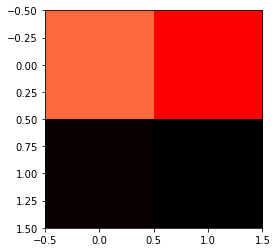

In [14]:
for fold in range(k_fold_value):
    
    if not trial:
        log_file = open("run_files/model_" + str(fold) + ".txt","w")
        model_output_name = "run_files/model_" + str(fold) + ".pth"
        
    piece_count = fold + 1
    
    train,valid,piece_count = su.CV.get_K_fold_cv_data(train_valid_df,k_fold_value,piece_count,shuffle_output=True)

    x_train_fp,y_train_fp = su.DNN.smiles_to_fp(train,fingerprint_type,fp_radius,fingerprint_size)
    x_valid_fp,y_valid_fp = su.DNN.smiles_to_fp(valid,fingerprint_type,fp_radius,fingerprint_size)
    if fold == 0:
        x_test_fp,y_test_fp = su.DNN.smiles_to_fp(test_df,fingerprint_type,fp_radius,fingerprint_size)
    
    
    train_loader = su.CV.get_dataloader(x_train_fp,y_train_fp,batch_size)
    valid_loader = su.CV.get_dataloader(x_valid_fp,y_valid_fp,batch_size)
    if fold == 0:
        test_loader = su.CV.get_dataloader(x_test_fp,y_test_fp,batch_size)

    if not trial:
        train_class_distriution = su.DNN.get_cluster_count_from_label(y_train_fp)
        valid_class_distriution = su.DNN.get_cluster_count_from_label(y_valid_fp)
        test_class_distriution = su.DNN.get_cluster_count_from_label(y_test_fp)
        log_file.write("Training : Class distribution = " + str(train_class_distriution) + "\n")
        log_file.write("Valid : Class distribution = " + str(valid_class_distriution) + "\n")
        log_file.write("Test : Class distribution = " + str(test_class_distriution) + "\n")
    
    # calculate class_weight
    if enable_class_weight:
        class_weight = torch.FloatTensor(su.get_class_weight(train)).cuda()
        if not trial:
            log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
    
    # Build model
    model = Net(p1=0.4,p2=0.4)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if enable_class_weight:
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    
    
    # List to store values
    train_loss_list = []
    train_accu_list = []

    val_loss_list = []
    val_accu_list = []
    
    
    # model training
    loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
    for epoch in loop:

        train_loss, train_accu = su.DNN.train(model,criterion,optimizer,train_loader,device)
        val_loss,val_accu = su.DNN.validate(model,criterion,valid_loader,device)
        
        if epoch == 0: # For callback
            torch.save(model.state_dict(), model_output_name)
            saved_model_id = epoch + 1
        else:
            current_epoch_values = [train_loss, train_accu,val_loss,val_accu]
            previous_epoch_values = [train_loss_list,train_accu_list,val_loss_list,val_accu_list]
            if su.callback(current_epoch_values,previous_epoch_values,model,model_output_name):
                saved_model_id = epoch + 1
        
        train_loss_list.append(train_loss)
        train_accu_list.append(train_accu)
        val_loss_list.append(val_loss)
        val_accu_list.append(val_accu)
        
        if not trial:
            log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        loop.set_description("LOSS train:" + str(train_loss) + " val:" + str(val_loss) + " \tACCU train:" + str(train_accu) + " val:" + str(val_accu))
    
    log_file.write("\nChosen model = epoch number " + str(saved_model_id))
    
    model = Net(p1=0.4,p2=0.4)
    model.load_state_dict(torch.load(model_output_name), strict=True)
    model.to(device)
    
    
    if not trial: # classification report and confusion matrix plot
        loss,accuracy,prediction_list = su.DNN.test(model,criterion,train_loader,device)
        image_name = "run_files/train_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTrain data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Train data report \n-" + str(report) + "\n\n\n\n\n")
    
        loss,accuracy,prediction_list = su.DNN.test(model,criterion,valid_loader,device)
        image_name = "run_files/valid_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nValid data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Valid data report \n-" + str(report) + "\n\n\n\n\n")
        
        loss,accuracy,prediction_list = su.DNN.test(model,criterion,test_loader,device)
        image_name = "run_files/test_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTest data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Test data report \n-" + str(report) + "\n\n\n\n\n")
    
    log_file.close()
    
    if fold == 0 and not trial:
        network_parameter_output.write("model = " + str(model) + "\n")
        network_parameter_output.close()
    
    # best validation loss
    index = val_loss_list.index(sorted(val_loss_list)[0]) # index of least loss
    print ("Best model")
    print ("LOSS train:",train_loss_list[index]," val:",val_loss_list[index], "\tACCU train:",train_accu_list[index]," val:",val_accu_list[index])
    print ("Final model")    
    print ("LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

In [26]:
class_weight

NameError: name 'class_weight' is not defined